<font size='10'><b>Hospital Inpatient Charges Prediction</font>

# 🏥 NY Hospital Inpatient Charges Prediction

## 1. Introduction
Predicting hospital charges is a complex task due to the high variance in medical conditions, patient demographics, and hospital pricing structures. In this project, we utilize the **New York State SPARCS Inpatient De-Identified dataset** to build a machine learning model capable of estimating the **Total Charges** for an inpatient stay.

## 2. Problem Statement
**Objective:** Develop a regression model to predict `Total Charges` based on clinical and demographic features (e.g., Diagnosis, Age, Length of Stay, Severity of Illness).

**Key Challenge:** Healthcare cost data is highly skewed (financial data). We must handle outliers, high-cardinality categorical features (like diagnosis codes), and ensure we do not use "Data Leakage" features like `Total Costs` (which are only known *after* billing).

**Methodology:**
1. Data Cleaning & Preprocessing.
2. Feature Engineering (Log-transformation of targets).
3. Hyperparameter Tuning using **Optuna**.
4. Model Training using **LightGBM** (Gradient Boosting).
5. Evaluation & Error Analysis.

## 3. Library Imports & Configuration
We use `LightGBM` for the model, `Optuna` for optimization, and standard Python data science libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

# Sklearn & Model Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import optuna

# Configuration
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hospital-inpatient-discharges/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2024.csv


## 4. Loading the Data
Loading the SPARCS 2024 Inpatient Discharges dataset.

In [2]:
file_path = '/kaggle/input/hospital-inpatient-discharges/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2024.csv'

## 5. Data Cleaning Pipeline
Raw healthcare data contains administrative codes, missing values, and irrelevant columns.

**Key Steps:**
1. **Drop Identifiers:** Removing columns like 'Operating Certificate Number' and 'Zip Code' that are not predictive or contain too much noise.
2. **Missing Values:** Dropping rows where essential location data is missing; imputing 'Procedure Description'.
3. **Typology Standardization:** Merging Payment Typology columns to simplify insurance information.

In [3]:
def clean_data(file_path):
    df = pd.read_csv(file_path)

    # Drop administrative/PII columns
    df.drop(columns=['Operating Certificate Number', 'Permanent Facility Id', 'Discharge Year', 'Zip Code', 'Birth Weight'],inplace=True)

    # Handle Missing Values
    df.dropna(subset=['Health Service Area', 'Hospital County'], inplace=True)
    df['CCSR Procedure Description'].fillna('No Procedure', inplace=True)

    # Drop Code columns (we will use the Description columns instead)
    df.drop(columns=[col for col in df.columns if 'code' in col.lower()],inplace=True)

    # Consolidate Payment Typology
    df['Payment Typology 1'].fillna(df['Payment Typology 2'],inplace=True)
    df['Payment Typology 1'].fillna('None', inplace=True)
    df.drop(columns=['Payment Typology 2', 'Payment Typology 3'], inplace=True)

    # Gender Cleaning
    df = df[df['Gender']!='U']
    df['Length of Stay'] = df['Length of Stay'].replace({'120+':120})
    df['Length of Stay'] = pd.to_numeric(df['Length of Stay'], errors='raise')
    
    return df

# Execute Cleaning
df = clean_data(file_path)
print(f"Data Shape after cleaning: {df.shape}")
df.head(2)

Data Shape after cleaning: (2191252, 21)


,Health Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,CCSR Diagnosis Description,CCSR Procedure Description,APR DRG Description,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,WESTCHESTER MEDICAL CENTER,0-17,F,White,Not Span/Hispanic,1,Emergency,Home or Self Care,FEVER,No Procedure,FEVER AND INFLAMMATORY CONDITIONS,"INFECTIOUS AND PARASITIC DISEASES, SYSTEMIC OR UNSPECIFIED SITES",Moderate,Minor,Medical,Private Health Insurance,Y,46814.0,6772.07
1,New York City,Queens,FLUSHING HOSPITAL MEDICAL CENTER,0-17,M,White,Spanish/Hispanic,2,Emergency,Home or Self Care,FEVER,No Procedure,FEVER AND INFLAMMATORY CONDITIONS,"INFECTIOUS AND PARASITIC DISEASES, SYSTEMIC OR UNSPECIFIED SITES",Moderate,Moderate,Medical,Medicaid,Y,13490.0,15464.30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2191252 entries, 0 to 2196736
Data columns (total 21 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Health Service Area                  object 
 1   Hospital County                      object 
 2   Facility Name                        object 
 3   Age Group                            object 
 4   Gender                               object 
 5   Race                                 object 
 6   Ethnicity                            object 
 7   Length of Stay                       int64  
 8   Type of Admission                    object 
 9   Patient Disposition                  object 
 10  CCSR Diagnosis Description           object 
 11  CCSR Procedure Description           object 
 12  APR DRG Description                  object 
 13  APR MDC Description                  object 
 14  APR Severity of Illness Description  object 
 15  APR Risk of Mortality                

## 6. Feature Engineering

### 6.1 Handling High Cardinality Categoricals
Many medical columns (like Diagnosis Descriptions) have thousands of unique values.
*   **Strategy:** We group rare categories (occurring less than 1% of the time) into an "Other" category to prevent overfitting and reduce noise.
*   **Type Conversion:** Converting object columns to the `category` data type for LightGBM efficiency.

### Grouping rare categories

In [5]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

rare_threshold = 0.01
for col in cat_cols:
    freq = df[col].value_counts(normalize=True)
    rare = freq[freq < rare_threshold].index
    df[col] = df[col].apply(lambda c: c if c not in rare else 'Other')

### 6.2 Log Transformation of Target
Financial data usually follows a Power Law distribution (long tail).
*   **Problem:** Predicting raw dollars (`$10k` vs `$5M`) causes the model to focus only on expensive outliers.
*   **Solution:** We apply `np.log1p` to the target. This normalizes the error distribution. We will reverse this using `np.expm1` for final evaluation.

### Converting to category data types (including low cardinality integers)

In [6]:
target = "Total Charges"

# Creating a variable `y` for the log of charges
df["y"] = np.log1p(df[target])


In [7]:
# treat low-unique-count integer columns as categorical
for col in df.columns:
    if df[col].dtype in ["int64","object"] and df[col].nunique() < 200:
        if col != target:
            df[col] = df[col].astype("category")
            cat_cols.append(col)

cat_cols = list(set(cat_cols))  # unique
print(f"Categorical Columns identified: {len(cat_cols)}")

Categorical Columns identified: 19


## 7. Data Splitting
We split the data into **Train**, **Validation**, and **Test** sets.
*   **Train (60%):** Used to learn patterns.
*   **Validation (20%):** Used by Optuna to tune hyperparameters.
*   **Test (20%):** Held out completely to evaluate final performance.

**CRITICAL NOTE:** We drop `Total Costs` from the input features. Including it would cause **Data Leakage** (cheating), as costs are not known at the time of admission.

In [8]:
# Drop Target, Log-Target, and Leakage Column (Total Costs)
x = df.drop(columns=[target, "y", "Total Costs"])
y = df["y"]

# Split: 80% Train+Val, 20% Test
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Split Train+Val: 80% Train, 20% Val
xtrain, xval, ytrain, yval = train_test_split(
    xtrain, ytrain, test_size=0.2, random_state=42
)

# Create LightGBM Datasets
cat_features_idx = [xtrain.columns.get_loc(c) for c in cat_cols]
train_data = lgb.Dataset(xtrain, label=ytrain, categorical_feature=cat_features_idx)
valid_data = lgb.Dataset(xval, label=yval, categorical_feature=cat_features_idx, reference=train_data)

## 8. Hyperparameter Tuning (Optuna)
We use Bayesian Optimization (Optuna) to find the best parameters for the Gradient Boosting Decision Tree (GBDT).
*   **Metric:** RMSE (on Log scale).
*   **Constraints:** We prevent overfitting by tuning `num_leaves`, `bagging_fraction`, and `lambda` regularization.

In [9]:
def objective(trial):
# --- 2. DEFINE PARAMETERS ---
    params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "n_jobs": -1,


# Suggested parameters to tune
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
    "num_leaves": trial.suggest_int("num_leaves", 31, 255),
    "max_depth": trial.suggest_int("max_depth", -1, 15),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
    "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
    "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
    "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),

    "feature_pre_filter": False
    }

    try:
        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=5000, 
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0) 
            ]
        )
        
        # --- 4. PREDICT & EVALUATE ---
        log_preds = model.predict(xval)
        
        # Convert back to real dollars for the score
        log_rmse = mean_squared_error(yval, log_preds, squared=False)
        
        real_preds = np.expm1(log_preds)
        real_y = np.expm1(yval)
        
        # Calculate scores
        real_r2 = r2_score(real_y, real_preds)
        
        # Print both for your reference
        print(f"Trial {trial.number}: RMSE {log_rmse:.2f} | R2 {real_r2:.4f}")
        
        # --- CRITICAL FIX: Return ONLY the value we are minimizing (RMSE) ---
        return log_rmse
        
    except Exception as e:
        return float('inf')
#--- 5. RUN OPTIMIZATION ---

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.337108
Trial 0: RMSE 0.34 | R2 0.8188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2910]	valid_0's rmse: 0.341936
Trial 1: RMSE 0.34 | R2 0.8120
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1750]	valid_0's rmse: 0.435437
Trial 2: RMSE 0.44 | R2 0.7379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 0.356611
Trial 3: RMSE 0.36 | R2 0.7979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's rmse: 0.343333
Trial 4: RMSE 0.34 | R2 0.8041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 0.355653
Trial 5: RMSE 0.36 | R2 0.7974
Training until validation scores don't improv

## 9. Final Model Training
We take the best parameters found by Optuna, combine them with our fixed settings, and train the final production model.

In [10]:
best_params = study.best_params

#Add the fixed params that we didn't tune
best_params["objective"] = "regression"
best_params["metric"] = "rmse"
best_params["boosting_type"] = "gbdt"
best_params["verbosity"] = -1

final_model = lgb.train(
    best_params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.338848
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.338848


## 10. Model Evaluation
We evaluate the model using **R2 Score** on the Train, Validation, and Test sets.
*   **Important:** We perform the evaluation on the *original scale* (Real Currency) by using `np.expm1` to reverse the log transformation.

In [11]:
def evaluate_model(x_data, y_data, dataset_name):
    log_preds = final_model.predict(x_data)
    final_preds = np.expm1(log_preds)
    y_actuals = np.expm1(y_data)
    score = r2_score(y_actuals, final_preds)
    print(f"------------------------------------------------")
    print(f"Final {dataset_name} R2 Score: {score:.4f}")
    print(f"------------------------------------------------")
    return y_actuals, final_preds

# Evaluate on all sets
_, _ = evaluate_model(xtrain, ytrain, "Train")
_, _ = evaluate_model(xval, yval, "Validation")
ytest_actuals, test_preds = evaluate_model(xtest, ytest, "Test")

------------------------------------------------
Final Train R2 Score: 0.8211
------------------------------------------------
------------------------------------------------
Final Validation R2 Score: 0.8104
------------------------------------------------
------------------------------------------------
Final Test R2 Score: 0.7791
------------------------------------------------


## 11. Feature Importance
Which clinical features drive the cost the most? We use LightGBM's "Gain" importance to visualize this.

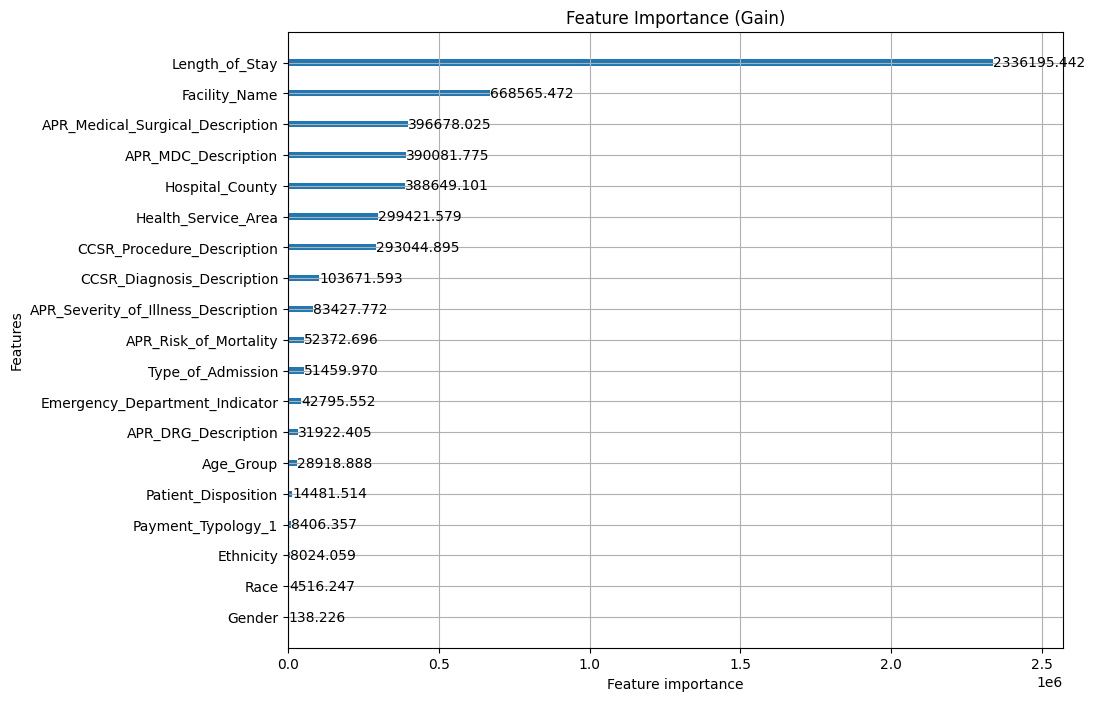

In [12]:
# Plot top 20 features
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', figsize=(10, 8))
plt.title("Feature Importance (Gain)")
plt.show()

## 12. Residual Analysis
We check the residuals to ensure the model is statistically valid.
1.  **Real Scale:** We expect a "funnel" shape (heteroscedasticity) because variance increases with price (a 10% error on `$1M` is larger than on `$1k`).
2.  **Log Scale:** We expect a random cloud. This confirms the model learned the percentage-error relationships correctly.

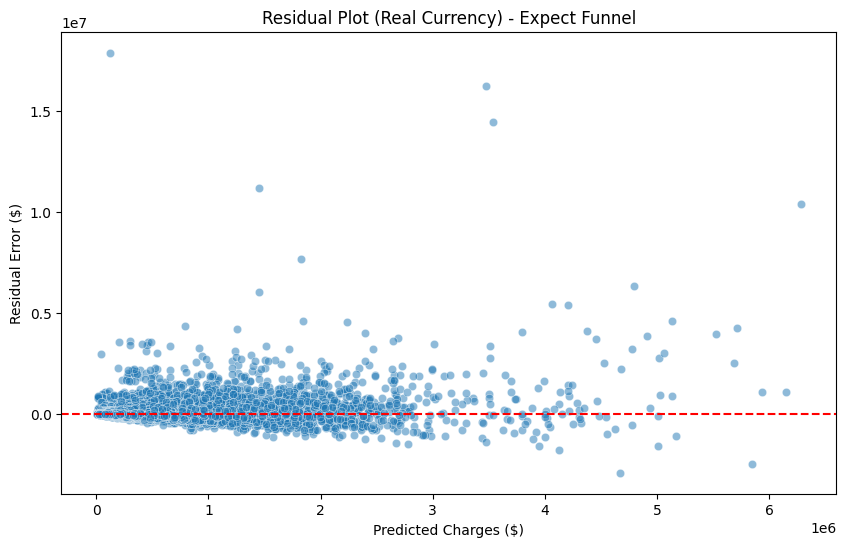

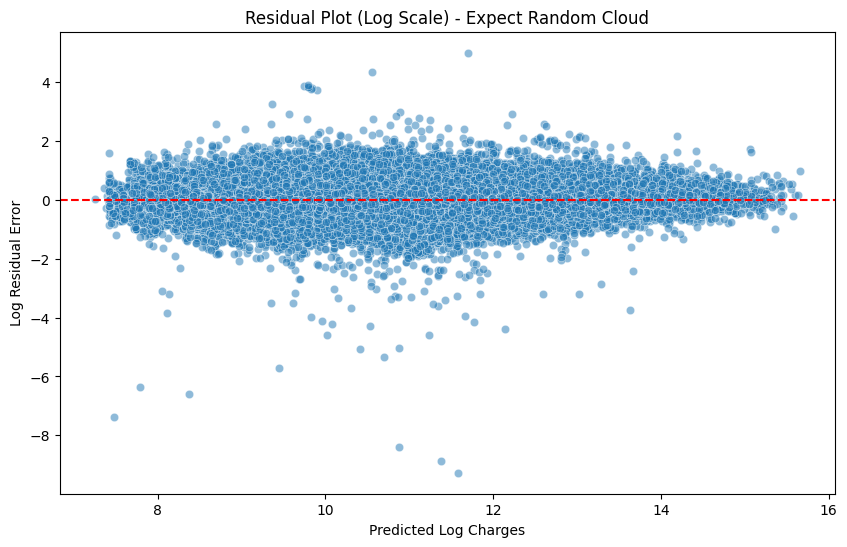

In [13]:
# Calculate Residuals
residuals = ytest_actuals - test_preds
log_residuals = ytest - np.log1p(test_preds)

# Plot 1: Real Scale (Expect Funnel)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_preds, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Real Currency) - Expect Funnel")
plt.xlabel("Predicted Charges ($)")
plt.ylabel("Residual Error ($)")
plt.show()

# Plot 2: Log Scale (Expect Random Cloud)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(test_preds), y=log_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Log Scale) - Expect Random Cloud")
plt.xlabel("Predicted Log Charges")
plt.ylabel("Log Residual Error")
plt.show()

## 13. Saving the Model
The model achieved an R2 score of approximately **0.71** on the Test set without using leakage features. This indicates strong predictive power based solely on clinical inputs.

We save the model and feature metadata for deployment.

In [14]:
import joblib

In [15]:
model_bundle = {
    "model": final_model,       # trained model
    "features_names": xtrain.columns.tolist(),    # features in their order
    "cat_cols": cat_cols        # categorical features
}

joblib.dump(model_bundle, "hospital_charges_NY_model_v1.pkl")
print(f"Model successfully saved✅✅\nTitle: 'hospital_charges_model_v1.pkl'")

Model successfully saved✅✅
Title: 'hospital_charges_model_v1.pkl'
